# Analysis of UK MPs Use of Hope and Nostalgia in Youtube Videos.

In this Jupyter Notebook, I use the classifier trained in [Hope_Nostalgia_Classifier_Training.ipynb](https://github.com/BeJa1996/political_hope_nostalgia/blob/main/Hope_Nostalgia_Classifier_Training.ipynb)on my MP dataset from [UK_MP_Youtube_ChannelsVideosTranscripts.ipynb](https://github.com/BeJa1996/political_hope_nostalgia/blob/main/UK_MP_Youtube_ChannelsVideosTranscripts.ipynb).

# Imports

In [1]:
# General Packages
import pandas as pd
import numpy as np
import re # for text-cleaning
import random
import warnings
from joblib import dump, load
import itertools
import time
SEED_GLOBAL = 1984

# Machine Learning and NL Analysis
from sklearn.naive_bayes import MultinomialNB
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from sklearn.metrics import cohen_kappa_score

# Transformer Packages (Laurer, 2023)
#!pip install datasets
#!pip install transformers==4.40.0 # in Colab I got an error with the trainer when I did not download the most recent transformer
#!pip install accelerate -U
#import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import pipeline, TrainingArguments, Trainer, logging
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"  # use GPU (cuda) if available, otherwise use CPU

# Visualisation and Table handling
from google.colab import data_table, files
data_table.enable_dataframe_formatter() # to have tables which enable reading the text in full
import matplotlib.pyplot as plt
import seaborn as sns
# Parameters for all plots
plt.rcParams.update({'axes.spines.top': False,  #https://stackoverflow.com/a/28720127
                     'axes.spines.right': False,#
                     'axes.spines.bottom': False,
                     'axes.spines.left': False,
                     'axes.titlesize': 10, #https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html
                     'axes.titlepad': 10})

# Statistical analysis
from scipy import stats

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#https://www.geeksforgeeks.org/how-to-upload-folders-to-google-colab/

!git clone https://github.com/BeJa1996/political_hope_nostalgia/
!unzip political_hope_nostalgia/Training_Datasets.zip

Cloning into 'political_hope_nostalgia'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 67 (delta 24), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (67/67), 7.32 MiB | 6.49 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Archive:  political_hope_nostalgia/Training_Datasets.zip
   creating: Training_Datasets/
  inflating: Training_Datasets/data_polnos_handcoding.csv  
  inflating: Training_Datasets/Task 2_Test_with_labels_English_PolyHope.csv  
  inflating: Training_Datasets/data_polnos_handcoding_validation.csv  


# Dataset preparations
The data which I gathered in my UK_MPs_Youtube_Transcripts Notebook, still needs some preparation for proper analysis. I discovered that in some texts there is \\n, which might pose problems in some code. Furthermore, some texts are far longer than the 512 characters which transformers can analyse. So I will need to split the transcripts.

In [4]:
transcripts = pd.read_csv('/content/political_hope_nostalgia/UK_MP_Youtube_videos.csv')
del(transcripts['Unnamed: 0'])
transcripts.head()

,videoId,title,publishedAt,channelId,channelTitle,transcript,viewCount,likeCount,commentCount
0,1V1OmMlrDLk,Rushanara Ali MP speaks in Channel 4 Immigrati...,2018-06-25T10:01:19Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,roughly as a politician what do you do you kno...,6417.0,37.0,4.0
1,cNXCDsgn4uE,Rushanara Ali MP - Intervention on the Occupie...,2020-09-25T10:11:17Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,will my honourable friend give way absolutely ...,68.0,1.0,0.0
2,IUo76cagovg,Rushanara Ali MP - PMQs 26 January,2022-01-26T12:41:13Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,thank you thank you mr speaker threats and int...,44494.0,220.0,5.0
3,fYZRE4Dcjf8,Rushanara Ali MP speaks in Urgent Question on ...,2020-06-16T12:47:22Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,we remember our dear friend Joe Cox today and ...,495.0,20.0,3.0
4,LVu9yrvVmVo,Rushanara Ali MP - ITV Interview on Government...,2020-06-03T15:52:51Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,it's very important that the government takes ...,228.0,12.0,2.0


### Remove Problematic Characters
Because I saw these escape sequences, I used the same pipeline as for tweet cleaning here. This will delete escape sequences and other potential impurities

In [5]:
transcripts.loc[918, 'transcript']

'(Music)  >> Delegates please welcome \nWendy Nichols and the pat form  party., if\n(Applause) clap (Applause) >> Delegates, can you take your \nseats and then we can start this afternoon\'s session. We\'ve obviously got a very \nimportant, can I ask you to  settle down and be quiet, if I \ndare say that - which I dare! I might say something different \nif it carries on, but can you  just settle down.  Be quiet. That means stopping talking for \nnow and listen to what we\'re  going to do. OOOHHH I told you I can be \ntetchy. OK, this afternoon we\'ll \ncontinue our  debate on our is international \nissues.  I have some information for you. It is clear the information \nprovided  to delegates   assisted in the \nvoting on reference back this  morning. To maximise information \navailable to  delegates for debates tomorrow, \nthe CAC  has made available the online \nform for  reference back the link can be \nfound at, I\'ll get this wrong. Https Https/Labour.org.\nUK/reference back form. 

In [6]:
# from https://www.kaggle.com/code/tariqsays/tweets-cleaning-with-python
transcripts['text'] = transcripts['transcript'].copy()
transcripts['text'] = transcripts['text'].astype('str')
transcripts['text'] = transcripts.apply(lambda row: row['text'].lower(),axis=1)
transcripts['text'] = transcripts.apply(lambda row: re.sub("@[A-Za-z0-9_]+","",
                                                     row['text']),axis=1)
transcripts['text'] = transcripts.apply(lambda row: re.sub("#[A-Za-z0-9_]+","",
                                                   row['text']),axis=1)
# i need to do it a second time, because anonymization lead to #User# which
# was not removed
transcripts['text'] = transcripts.apply(lambda row: re.sub("#","",
                                                   row['text']),axis=1)
transcripts['text'] = transcripts.apply(lambda row: re.sub(r"http\S+","",
                                                     row['text']),axis=1)
transcripts['text'] = transcripts.apply(lambda row: re.sub(r"www.\S+","",
                                                  row['text']),axis=1)
# in the following I added punctuation, so that this is not removed
transcripts['text'] = transcripts.apply(lambda row: re.sub("[^a-z0-9\.,;:']"," ",
                                                     row['text']),axis=1)
# Now there are some quite long spaces.
transcripts['text'] = transcripts.apply(lambda row: re.sub(" +"," ",
                                                     row['text']),axis=1)

In [7]:
transcripts.head()

,videoId,title,publishedAt,channelId,channelTitle,transcript,viewCount,likeCount,commentCount,text
0,1V1OmMlrDLk,Rushanara Ali MP speaks in Channel 4 Immigrati...,2018-06-25T10:01:19Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,roughly as a politician what do you do you kno...,6417.0,37.0,4.0,roughly as a politician what do you do you kno...
1,cNXCDsgn4uE,Rushanara Ali MP - Intervention on the Occupie...,2020-09-25T10:11:17Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,will my honourable friend give way absolutely ...,68.0,1.0,0.0,will my honourable friend give way absolutely ...
2,IUo76cagovg,Rushanara Ali MP - PMQs 26 January,2022-01-26T12:41:13Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,thank you thank you mr speaker threats and int...,44494.0,220.0,5.0,thank you thank you mr speaker threats and int...
3,fYZRE4Dcjf8,Rushanara Ali MP speaks in Urgent Question on ...,2020-06-16T12:47:22Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,we remember our dear friend Joe Cox today and ...,495.0,20.0,3.0,we remember our dear friend joe cox today and ...
4,LVu9yrvVmVo,Rushanara Ali MP - ITV Interview on Government...,2020-06-03T15:52:51Z,UC7iazTIj4W6EGAMs9CJrfJA,Rushanara Ali,it's very important that the government takes ...,228.0,12.0,2.0,it's very important that the government takes ...


### Split into chunks
As you can see, some texts are really long. Therefore, I wanted to adopt the approach of Müller and Proksch (2023) and split the texts into sentences. However, often there is no interpunctuation. Therefore, I split the text into chunks. Theoretically those could be as large as 512 tokens, but this appeared to long for manual checking of the results. Therefore, I split it in chunks of 250 tokens.

<Axes: >

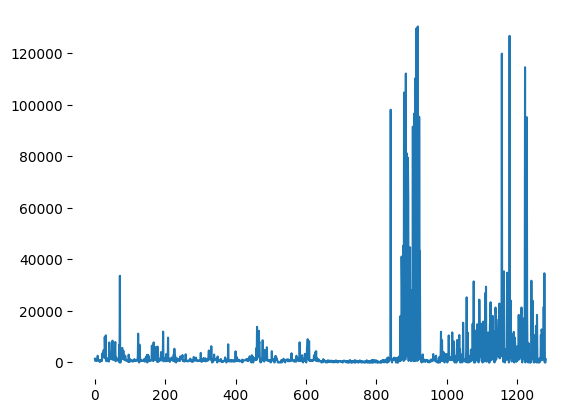

In [8]:
transcripts['text'].str.len().plot()

I create at first a function which splits the text into words and then combines them into chunks. Thereby, each chunk entails some of the words from the previous chunk. In this way, I ensure we do not lose the meaning of some word groups because they are split in half.

In [9]:
def chunking (text):
  words = word_tokenize(text, language='english')
  chunks = []
  word = 0
  while word < len(words):
    chunk = ' '.join(words[word:min(word+250, len(words))]) # min() to not get out of bounds error
    chunks.append(chunk)
    word = word + 220

  return chunks

In [12]:
transcripts['txt_split'] = transcripts.apply(lambda row: chunking(row['text']), axis = 1)
transcripts_prepared = transcripts.explode('txt_split') #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html
print(f"The length of the dataset increased from {len(transcripts)} to {len(transcripts_prepared)}.")

The length of the dataset increased from 1283 to 5154.


In [13]:
transcripts_prepared = transcripts_prepared[['videoId','title',  'viewCount', 'likeCount', 'commentCount', 'txt_split']]
transcripts_prepared = transcripts_prepared.rename(columns = {'txt_split': 'text'})
transcripts_prepared.head()

,videoId,title,viewCount,likeCount,commentCount,text
0,1V1OmMlrDLk,Rushanara Ali MP speaks in Channel 4 Immigrati...,6417.0,37.0,4.0,roughly as a politician what do you do you kno...
0,1V1OmMlrDLk,Rushanara Ali MP speaks in Channel 4 Immigrati...,6417.0,37.0,4.0,do n't really like the word tolerant to be fra...
1,cNXCDsgn4uE,Rushanara Ali MP - Intervention on the Occupie...,68.0,1.0,0.0,will my honourable friend give way absolutely ...
2,IUo76cagovg,Rushanara Ali MP - PMQs 26 January,44494.0,220.0,5.0,thank you thank you mr speaker threats and int...
3,fYZRE4Dcjf8,Rushanara Ali MP speaks in Urgent Question on ...,495.0,20.0,3.0,we remember our dear friend joe cox today and ...


In how many chunks did we split the videos now?

In [14]:
counts = transcripts_prepared.groupby('title')['title'].count()
counts.sort_values(ascending = False)

title
Labour Party Annual Conference 2019: Monday Afternoon                      122
Labour Party Annual Conference 2018: Monday Afternoon                      119
Conservative Party Conference Day 3 - Morning - #CPC18 - Part 2            109
Conservative Party Conference 2018 - Day 1 - Sunday 30th September         101
Labour Party Annual Conference 2018: Tuesday Afternoon                     101
                                                                          ... 
It&#39;s a Tory government by – and for – the super-rich                     1
It&#39;s time for a Labour government.                                       1
It&#39;s time for a general election and economic stability with Labour      1
It&#39;s time for change.  #ukpolitics #recession #rishisunak                1
🚨 TORY TAX HIKE REVEALED 🚨                                                   1
Name: title, Length: 1283, dtype: int64

# Classifier Application

## Functions
Clean_memory and inference are the same as in [Hope_Nostalgia_Classifier_Training.ipynb](https://github.com/BeJa1996/political_hope_nostalgia/blob/main/Hope_Nostalgia_Classifier_Training.ipynb). They are basically directly taken from Laurer (2023) or adapted.

analysis was created in this notebook.

### clean_memory

In [ ]:
# helper function to clean memory and reduce risk of out-of-memory error
import gc
def clean_memory():
  #del(model)
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
  gc.collect()

clean_memory()

### inference

In [ ]:
def inference(name, df_test, model_name, seed = None, nli = False, hypo_label_dict = {}):

  clean_memory()

  print('Initializing Tokenizer') #bj
  tokenizer = AutoTokenizer.from_pretrained(model_name,
                                            use_fast=True,
                                            model_max_length=512,
                                            truncation = True,
                                            add_special_tokens = True)

  print('\nInitializing Pipeline')
  if nli == True:
    if not hypo_label_dict: # https://stackoverflow.com/a/23177452/23292830
        raise Exception("No Dictionary") #https://www.w3schools.com/python/gloss_python_raise.asp
    hypothesis_lst = list(hypo_label_dict.values())

    pipe_classifier = pipeline(
      "zero-shot-classification",
      model= model_name,
      tokenizer=tokenizer,
      framework="pt",
      device=device,
      set_seed = seed
    )
  else:
    pipe_classifier = pipeline(
      "text-classification",
      model=model_name,  # if you have trained a model above, load_best_model_at_end in the training arguments has automatically replaced model with the fine-tuned model
      tokenizer=tokenizer,
      framework="pt",
      device=device,
  )

  # Create dummy dataset  #bj
  df_inference = df_test.copy(deep=True)
  text_lst = df_inference["text"].tolist()

  # use the pipeline with your chosen model for inference (prediction)
  print('\nPredicting ...') #bj

  if nli == True:
    pipe_output = pipe_classifier(
        text_lst,  # input any list of texts here
        candidate_labels=hypothesis_lst,
        hypothesis_template="{}",
        multi_label=False,  # here you can decide if, for your task, only one hypothesis can be true, or multiple can be true
        batch_size=32, # reduce this number to 8 or 16 if you get an out-of-memory error
        truncation = True,
        max_length = 512
    )

    # extract the predictions from pipe_outut
    hypothesis_pred_true_probability = []
    hypothesis_pred_true = []
    for dic in pipe_output:
      hypothesis_pred_true_probability.append(dic["scores"][0])
      hypothesis_pred_true.append(dic["labels"][0])

    # map the long hypotheses to their corresponding short label names
    hypothesis_label_dic_inference_inverted = {value: key for key, value in hypo_label_dict.items()}
    label_pred = [hypothesis_label_dic_inference_inverted[hypo] for hypo in hypothesis_pred_true]

    # add inference data to your original dataframe
    df_inference[f"{name}_pred"] = label_pred
    df_inference[f"{name}_prob"] = hypothesis_pred_true_probability

  else:
    pipe_output = pipe_classifier(
      text_lst,  # input any list of texts here
      batch_size=32,  # reduce this number to 8 or 16 if you get an out-of-memory error
      truncation = True,
      max_length = 512
      )
    df_output = pd.DataFrame(pipe_output)

    df_inference[f"{name}_pred"] = df_output["label"].tolist()
    df_inference[f"{name}_prob"] = df_output["score"].round(2).tolist()

  return df_inference

### analysis
I consolidate all inferences into one function.

In [ ]:
def analysis(emotion, df):
  # Naive Bayes
  print('\nNaive Bayes')
  nb = load(f"/content/political_hope_nostalgia/{emotion}_nb_model.joblib")
  nb_pred = nb.predict(df['text'])

  # Distilbert
  print('\nDistilbert')
  model = f"beja1996/distilbert-base-uncased_finetuned_{emotion}" # Getting the Fine-Tuned Model from Huggingface
  distilbert = inference(f'{emotion}_distilbert', df, model)

  # Deberta
  print('\nDeberta')
  model = f"beja1996/deberta-v3-base_finetuned_{emotion}" # Getting the Fine-Tuned Model from Huggingface
  deberta = inference(f'{emotion}_deberta', df, model)

  # Zero Shot
  print('\nZero Shot')
  if emotion == 'nostalgia':
    hypotheses = {
        "Nostalgia": "The text expresses nostalgia, it speaks positive about events and objects in the past or the past in general.",
        "Not Nostalgia": "The text does not express nostalgia."
    }
  else:
    hypotheses = {
        "Hope": "The text expresses hope, a future-oriented expectation, desire or wish towards a general or specific event.",
        "Not Hope": "The text does not express hope, wish, desire, or future-oriented expectation."
    }
  model = f"beja1996/deberta-v3-base-zeroshot-v2.0_finetuned_{emotion}" # Getting the Fine-Tuned Model from Huggingface
  zeroshot = inference(f'{emotion}_zeroshot', df, model, SEED_GLOBAL, True, hypotheses)

  print('\nJoining')
  df[f'{emotion}_nb'] = nb_pred
  df = pd.concat([df,
            distilbert[[f'{emotion}_distilbert_pred']],
            deberta[[f'{emotion}_deberta_pred']],
            zeroshot[[f'{emotion}_zeroshot_pred']]
            ],
            axis= 1)

  return df

## Classification

In [ ]:
transcripts_prepared = analysis('nostalgia', transcripts_prepared)


Naive Bayes

Distilbert
Initializing Tokenizer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]


Initializing Pipeline


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Predicting ...

Deberta
Initializing Tokenizer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]


Initializing Pipeline


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]


Predicting ...

Zero Shot
Initializing Tokenizer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]


Initializing Pipeline


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]


Predicting ...

Joining


In [ ]:
transcripts_prepared = analysis('hope', transcripts_prepared)


Naive Bayes

Distilbert
Initializing Tokenizer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]


Initializing Pipeline


config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Predicting ...

Deberta
Initializing Tokenizer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]


Initializing Pipeline


config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]


Predicting ...

Zero Shot
Initializing Tokenizer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]


Initializing Pipeline


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]


Predicting ...

Joining


I saved the dataset and uploaded it to Github

In [ ]:
transcripts_prepared['nostalgia_nb'] = np.where(transcripts_prepared['nostalgia_nb'] == 1, 'Nostalgia', 'Not Nostalgia')
transcripts_prepared['video_part'] = transcripts_prepared.groupby('videoId').cumcount(ascending=True)

cols = []
for col in transcripts_prepared.columns: # columns gives me a list of colum names
  cols.append(col.replace('_pred', '')) # each colum name is a string, so i can just replace it
transcripts_prepared.columns = cols #you can give columns a new name through inserting a list

In [ ]:
transcripts_prepared.to_csv('transcripts_analysed.csv')

# Analysis

At first, I import the dataset from my Github. If you just created a new dataset, you should comment the following code out.

In [3]:
#ntranscripts_analysed = transcripts_prepared #uncomment if you have run the previous analyses
transcripts_analysed = pd.read_csv('/content/political_hope_nostalgia/transcripts_analysed.csv')
del(transcripts_analysed['Unnamed: 0'])

In [16]:
transcripts_analysed.loc[:, transcripts_analysed.columns != 'text'].head()

,videoId,title,viewCount,likeCount,commentCount,nostalgia_nb,nostalgia_distilbert,nostalgia_deberta,nostalgia_zeroshot,hope_nb,hope_distilbert,hope_deberta,hope_zeroshot,video_part
0,1V1OmMlrDLk,Rushanara Ali MP speaks in Channel 4 Immigrati...,6417.0,37.0,4.0,Not Nostalgia,Not Nostalgia,Nostalgia,Not Nostalgia,Not Hope,Not Hope,Not Hope,Not Hope,0
1,1V1OmMlrDLk,Rushanara Ali MP speaks in Channel 4 Immigrati...,6417.0,37.0,4.0,Not Nostalgia,Not Nostalgia,Nostalgia,Not Nostalgia,Not Hope,Not Hope,Not Hope,Not Hope,1
2,cNXCDsgn4uE,Rushanara Ali MP - Intervention on the Occupie...,68.0,1.0,0.0,Not Nostalgia,Not Nostalgia,Not Nostalgia,Not Nostalgia,Hope,Not Hope,Not Hope,Not Hope,0
3,IUo76cagovg,Rushanara Ali MP - PMQs 26 January,44494.0,220.0,5.0,Not Nostalgia,Not Nostalgia,Nostalgia,Not Nostalgia,Not Hope,Not Hope,Not Hope,Hope,0
4,fYZRE4Dcjf8,Rushanara Ali MP speaks in Urgent Question on ...,495.0,20.0,3.0,Not Nostalgia,Not Nostalgia,Nostalgia,Not Nostalgia,Hope,Not Hope,Not Hope,Not Hope,0


Then I create some different representations of the data.

In [12]:
classifier = ['nb', 'distilbert', 'deberta', 'zeroshot']

In [13]:
value_vars = [x+str(y) for x in ['hope_', 'nostalgia_'] for y in classifier] #https://stackoverflow.com/a/41191073/23292830
transcripts_melted = transcripts_analysed.melt(id_vars = ['videoId', 'video_part'], value_vars=value_vars)
transcripts_melted.head()

,videoId,video_part,variable,value
0,1V1OmMlrDLk,0,hope_nb,Not Hope
1,1V1OmMlrDLk,1,hope_nb,Not Hope
2,cNXCDsgn4uE,0,hope_nb,Hope
3,IUo76cagovg,0,hope_nb,Not Hope
4,fYZRE4Dcjf8,0,hope_nb,Hope


In [14]:
counts = transcripts_melted.groupby(['variable', 'value'], as_index = False).count()
counts = counts[['variable', 'value', 'videoId']]
counts.columns = ['Classifier', 'Classification', 'Occurances']
counts['Classifier'] = counts['Classifier'].str.split('_').str[1]
counts

,Classifier,Classification,Occurances
0,deberta,Hope,1665
1,deberta,Not Hope,3489
2,distilbert,Hope,1496
3,distilbert,Not Hope,3658
4,nb,Hope,2118
5,nb,Not Hope,3036
6,zeroshot,Hope,2084
7,zeroshot,Not Hope,3070
8,deberta,Nostalgia,2590
9,deberta,Not Nostalgia,2564


In [15]:
counts_pivot = counts.pivot(index = 'Classifier', columns = 'Classification', values = 'Occurances')
counts_pivot['Frequency of Hope in %'] = round(counts_pivot['Hope']/(counts_pivot['Hope'] + counts_pivot['Not Hope'])*100,2)
counts_pivot['Frequency of Nostalgia in %'] = round(counts_pivot['Nostalgia']/(counts_pivot['Nostalgia'] + counts_pivot['Not Nostalgia'])*100,2)

## How did the classifier perform?

### Examples
You can take a look at some examples. You can change the classifier, the emotion and whether you want to look at an example where the classifier thought the emotion was present or not.

Personally, I am not really impressed. In the case of nostalgia, the classifier seems to identify rather a past tense than nostalgia.

In [21]:
def example(classifier, emotion, included):
  classifier = f"{emotion.lower()}_{classifier}"
  classification = emotion.capitalize() if included else f"Not {emotion.capitalize()}"

  texts = transcripts_analysed.loc[transcripts_analysed[classifier] == classification,
                                   'text'].tolist()
  text = random.sample(texts, 1)
  return text[0]

In [22]:
example('nb','nostalgia', included = True )

"i visited bangkok for the asean meeting of asia pacific nations they embraced our role in their region because they prized our commitment to the rules based international system in mexico we talked about climate change in canada we talked about our joint campaign to protect journalists around the world from torture and arbitrary detention truth is we brits get a very warm welcome almost everywhere in the world ok maybe not in luxembourg but you know what i think the british people have had more than enough of eu leaders disrespecting british prime ministers so we 'll strive in good faith for a good deal but if the eu spurn the opportunity for a win win deal we will leave at the end of october no ifs no buts i hope we can stay good european neighbors and friends but we 'll be free to chart our own course as masters of our own destiny at home and abroad with a much more liberal and energetic approach to free trade as listen this trust has just been talking about but our vision of global

Do you want to test, how strongly your intuition corresponds to the decisions of the classifier?
You can play the following game to check that.
Provide the fucntion with a classifier and an emotion and it provides you with a random example. Then tell the game whether you think the emotion is present or not, and it tells you, what the classifier 'thought'.

In [7]:
def example_game(classifier, emotion):
  classifier = f"{emotion.lower()}_{classifier}"
  included = random.choice([True, False])
  classification = emotion.capitalize() if included else f"Not {emotion.capitalize()}"

  texts = transcripts_analysed.loc[transcripts_analysed[classifier] == classification,
                                   'text'].tolist()
  text = random.sample(texts, 1)
  print("################ Text Snippet ###############\n")
  display(text[0])

  print("\n################ Your guess ###############")
  guess = input(f'\nDoes this text depict {emotion} or not? (Yes, No)\n')
  # Ihad one time that this code did not work. Then I removed \n and it worked.
  # Then I included it again and it still worked. I would not replicate the error.

  print("\n################ Is it true? ###############")
  time.sleep(2)
  if guess == 'Yes' and included:
    print(f"\nCorrect, {classifier} also thought it depicts {emotion}.")
  elif guess =='No' and not included:
    print(f"\nCorrect, {classifier} also thought it does NOT depict {emotion}.")
  else:
    print(f"{classifier} disagrees with you on that. ")

In [10]:
example_game('distilbert','nostalgia')

################ Text Snippet ###############



"and we 're on course to go even further this year we said we 'd increase health spending and we 're investing more money in the nhs every year and extra 122.5 billion by 2014 we said we 'd raise the basic state pension and from next april it will rise by 530 a week that is an extra 275 a year the biggest increase in history now there are areas where we need to work harder immigration for example is still too high and we 'll do everything in our power to try and bring it down i also know that people want more than just a list of promises kept or policies delivered they want to see a change in values a government that 's on their side supporting those who do the right thing cracking down on those who do n't caring for those in need but stopping people taking out when they have no intention of putting back in protecting our free nhs but reforming it to make sure it will be there for our children and grandchildren recognizing that the family is the most important thing of all those are my


################ Your guess ###############

Does this text depict nostalgia or not? (Yes, No)
Yes

################ Is it true? ###############
nostalgia_distilbert disagrees with you on that. 


### Amount of Hope and Nostalgia according to Classifier

The transformers differ strongly in the amount of hope and nostalgia they detect. This might be surprising because their accuracy was relatively high, implying that they learned the same differentiation quite well. The classifiers differ less strongly on hope.

This might be because the nostalgia training data was well-formulated written text, whereas we analyse spoken text here. Twitter writing was closer to spoken text so that it might generalise better.

In general there seems to be more hope than nostalgia.

<ipython-input-16-987e6605b453>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['Naive Bayes', 'Distilbert', 'Deberta', 'Zeroshot']) #https://stackoverflow.com/a/71602828


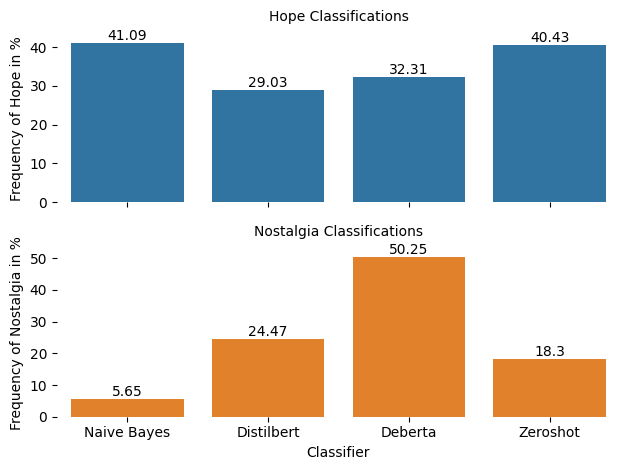

In [16]:
fig, ax = plt.subplots(2, sharex = True) #https://stackoverflow.com/q/14770735
sns.barplot(counts_pivot, y = 'Frequency of Hope in %', x = 'Classifier',
            ax = ax[0], order = classifier, color = "#1f77b4")
for i in ax[0].containers:
    ax[0].bar_label(i,)
ax[0].set_title('Hope Classifications')

sns.barplot(counts_pivot, y = 'Frequency of Nostalgia in %', x = 'Classifier',
            ax = ax[1], order = classifier, color = '#ff7f0e' )
for i in ax[1].containers: #https://www.geeksforgeeks.org/how-to-show-values-on-seaborn-barplot/
    ax[1].bar_label(i,)
ax[1].set_title('Nostalgia Classifications')
ax[1].set_xticklabels(['Naive Bayes', 'Distilbert', 'Deberta', 'Zeroshot']) #https://stackoverflow.com/a/71602828

plt.tight_layout(h_pad=1)
fig.savefig('amount_hope_nostalgia.png')

### Reliability
According to Grant et al. (2017), Cohens Kappa is a good reliability score  for binary classification tasks. Therefore, I will use it to compute the interrater agreement for all pairs of classifiers.

According to McHugh (2012) the interpretation is as follows:

>  "Cohen suggested the Kappa result be interpreted as follows: values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement."

In other words, for nostalgia, we find at most moderate reliabilities, namely between Distilbert and Zeroshot and Distilbert and Deberta. For hope, we see one substantial agreement between Deberta and Zeroshot and moderate agreement between Distilbert and Deberta and Distilbert and Zeroshot.

In [17]:
reliabilities = []
for a, b in itertools.combinations(classifier, 2): #https://stackoverflow.com/a/16603357
    row = []
    row.append(f"{a} and {b}")
    for emotion in ['nostalgia', 'hope']:
      kappa = cohen_kappa_score(transcripts_analysed[f"{emotion}_{a}"],
                             transcripts_analysed[f"{emotion}_{b}"])
      kappa = round(kappa, 3)
      row.append(kappa)

    reliabilities.append(row)

reliabilities = pd.DataFrame(reliabilities,
                             columns = ['Classifier', 'Hope', 'Nostalgia'])
reliabilities.to_csv('reliabilities.csv')
reliabilities

,Classifier,Hope,Nostalgia
0,nb and distilbert,0.193,0.280
1,nb and deberta,0.075,0.334
2,nb and zeroshot,0.196,0.325
3,distilbert and deberta,0.408,0.593
4,distilbert and zeroshot,0.516,0.522
5,deberta and zeroshot,0.333,0.623


As the agreement between the transformer models is mostly moderate and they had good f1 micro values constantly, I will consider them as seperate rater and create a compound score for the following analyses.

In [18]:
transcripts_analysed['hope_score'] = (transcripts_analysed['hope_deberta'] == 'Hope').astype('int')+ (transcripts_analysed['hope_distilbert'] == 'Hope').astype('int')+(transcripts_analysed['hope_zeroshot'] == 'Hope').astype('int')
transcripts_analysed['nostalgia_score'] = (transcripts_analysed['nostalgia_deberta'] == 'Nostalgia').astype('int')+ (transcripts_analysed['nostalgia_distilbert'] == 'Nostalgia').astype('int')+(transcripts_analysed['nostalgia_zeroshot'] == 'Nostalgia').astype('int')

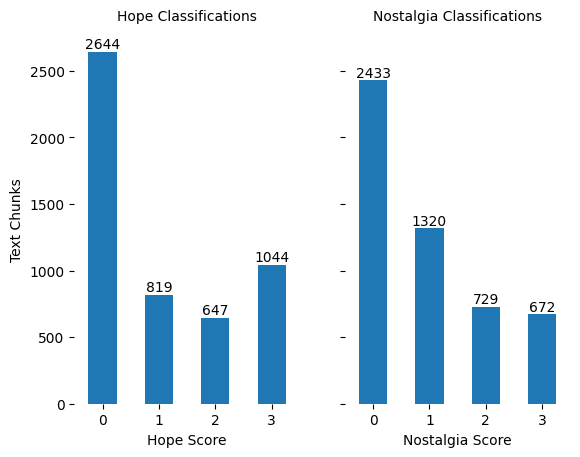

In [19]:
fig, ax = plt.subplots(1,2, sharey = True)
transcripts_analysed.groupby('hope_score')['hope_score'].count().plot.bar(ax = ax[0])
transcripts_analysed.groupby('nostalgia_score')['nostalgia_score'].count().plot.bar(ax = ax[1])

# Set Values https://www.geeksforgeeks.org/how-to-show-values-on-seaborn-barplot/
for i in ax[0].containers:
    ax[0].bar_label(i,)
for i in ax[1].containers:
    ax[1].bar_label(i,)

# Set Labels and Titles
ax[0].set_title('Hope Classifications')
ax[1].set_title('Nostalgia Classifications')
ax[0].set_ylabel('Text Chunks')
ax[0].set_xlabel('Hope Score')
ax[1].set_xlabel('Nostalgia Score')

#Rotate Labels
ax[0].tick_params(labelrotation=0)
ax[1].tick_params(labelrotation=0)

## Who uses more hope, who uses more nostalgia?

### Preparations
To analyse how the use of hope and nostalgia is different between progressives and conservatives, I need first to join the party information and the classification data.

First I combine the transcripts with the videos, to get the channelIDs and titles.

In [20]:
videos = pd.read_csv('/content/political_hope_nostalgia/UK_MP_Youtube_videos.csv')
channels = pd.read_csv('/content/political_hope_nostalgia/UK_MP_Youtube_channels.csv', sep = ';')
videos['videoId_video'] = videos['videoId'].astype('string')
transcripts_analysed['videoId'] = transcripts_analysed['videoId'].astype('string')

In [21]:
len(transcripts_analysed)

5154

In [22]:
len(videos)

1283

In [23]:
transcripts_videos = pd.merge(transcripts_analysed, videos[['videoId','channelId', 'channelTitle']],
                               how = 'left', on = 'videoId')
len(transcripts_videos)

5154

In [24]:
print(f'I have {sum(transcripts_videos.channelId.isna())} entries which where not found.')

I have 0 entries which where not found.


In [25]:
correct_channels = channels[channels['Correct'] == 'Yes']
transcripts_channels = pd.merge(transcripts_videos, correct_channels[['Channel_ID', 'Party']],
                               how = 'left', left_on = 'channelId',
                                right_on = 'Channel_ID', validate = 'm:1')
# Because the channels only pertain to MP's I need to manually insert the
# Official Party channels
transcripts_channels['Party'] = np.where(
    transcripts_channels['channelId'] == 'UCEBNsfXgUO74N70MJEhJQ1g',
    'Labour', transcripts_channels['Party']
    )
transcripts_channels['Party'] = np.where(
    transcripts_channels['channelId'] == 'UCXNSyuKeoiHOld1OS3kHuVg',
    'Conservative', transcripts_channels['Party']
    )

# Furthermore, I will change Labour/Co-operative  and Social Democratic and Labour Party into Labour
transcripts_channels['Party'] = np.where(
    transcripts_channels['Party'] == 'Labour/Co-operative',
    'Labour', transcripts_channels['Party']
    )
transcripts_channels['Party'] = np.where(
    transcripts_channels['Party'] == 'Social Democratic and Labour Party',
    'Labour', transcripts_channels['Party']
    )

# I create a column to differentiate between MP's and Party Account
transcripts_channels['Account Type'] = np.where(
    (transcripts_channels['channelId'] == 'UCXNSyuKeoiHOld1OS3kHuVg') |
    (transcripts_channels['channelId'] == 'UCEBNsfXgUO74N70MJEhJQ1g'),
    'Party', 'MP'
    )

# Lastly, I create a column to differentiate all four groups
transcripts_channels['Party, Account'] = transcripts_channels['Party'] + " " + transcripts_channels['Account Type']

len(transcripts_channels)

5154

In [26]:
print(f'I have {sum(transcripts_channels.Party.isna())} entries which where not found.')

I have 0 entries which where not found.


As the next graph shows, all in all, we have quite similar amounts of text chunks from Labour and Conservative. We furthermore see, that we have many more chunks from the party accounts than the MP accounts. Probably because they depict party conventions.

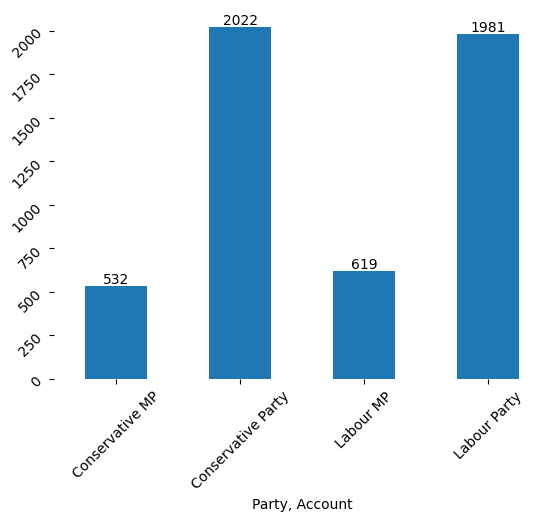

In [27]:
ax = transcripts_channels.groupby('Party, Account')['Party, Account'].count().plot.bar()
ax.tick_params(labelrotation=45)
for i in ax.containers:
    ax.bar_label(i,)

### Graphical Analysis

A first graphical overview suggests that the Conservatives use more hope and, at least on the party accounts, also more nostalgia.

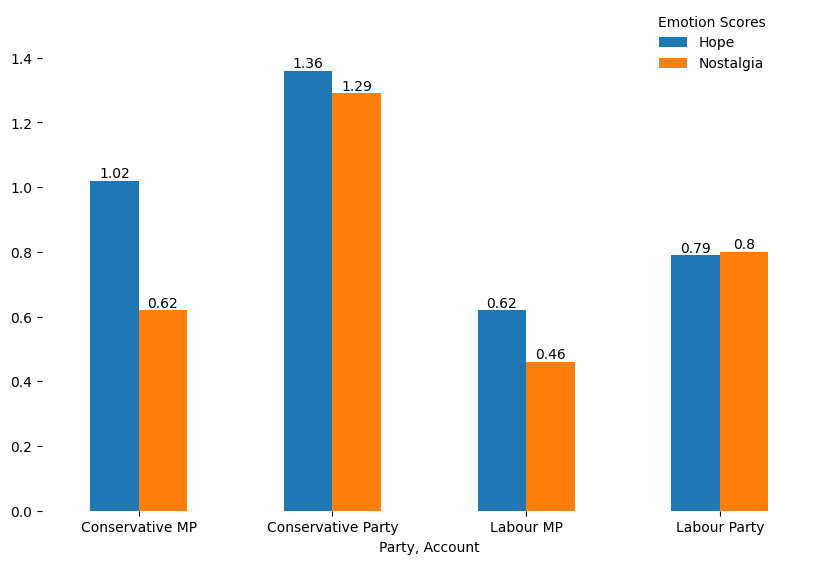

In [28]:
ax = transcripts_channels.groupby('Party, Account')[['hope_score',
                                                     'nostalgia_score']]
ax = ax.mean().round(2).plot.bar(figsize=(10, 6))
for i in ax.containers:
    ax.bar_label(i,)
ax.tick_params(labelrotation=0) #https://stackoverflow.com/a/37708190
leg = plt.legend(bbox_to_anchor=(0.95, 1.1), #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
           ncol =1,
           title = 'Emotion Scores',
           frameon=False,
           labels = ['Hope', 'Nostalgia']),
plt.savefig(f"emotion_scores_absolut.png")

However, because we have different numbers of chunks in the groups, we should set the results in relation to those numbers.

In [29]:
def chart_crosstab(column, title):

  # I want to change colours acccording to Emotion
  cmap = plt.colormaps.get_cmap('tab20c') #https://matplotlib.org/stable/gallery/color/individual_colors_from_cmap.html
  color = cmap(range(0,4)) if title == 'Hope Score' else cmap(range(4,8))
  # adapted from https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
  cross_tab = pd.crosstab(index=transcripts_channels['Party, Account'],
                          columns=transcripts_channels[column])
  cross_tab_prop = pd.crosstab(index=transcripts_channels['Party, Account'],
                          columns=transcripts_channels[column],
                          normalize="index")
  cross_tab_prop.plot(kind='bar',
                      stacked=True,
                      color=color,
                      figsize=(10, 6))
  leg = plt.legend(bbox_to_anchor=(0.95, 1.1),
            ncol =4,
            title = title,
            frameon=False)
  leg._legend_box.align = "left" #https://stackoverflow.com/a/44620643
  plt.tick_params(labelrotation=0)

  for n, x in enumerate([*cross_tab_prop.index.values]):
      for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                    cross_tab_prop.loc[x].cumsum()):

          plt.text(x=n - 0.17,
                  y=(y_loc - proportion) + (proportion / 2),
                  s=f'{np.round(proportion * 100, 1)}%',
                  color="black",
                  bbox=dict(facecolor='white',  #https://stackoverflow.com/a/17087794
                            boxstyle='round',
                            edgecolor='none',
                            alpha=0.5))
  plt.savefig(f"{column}.png")
  return cross_tab, cross_tab_prop

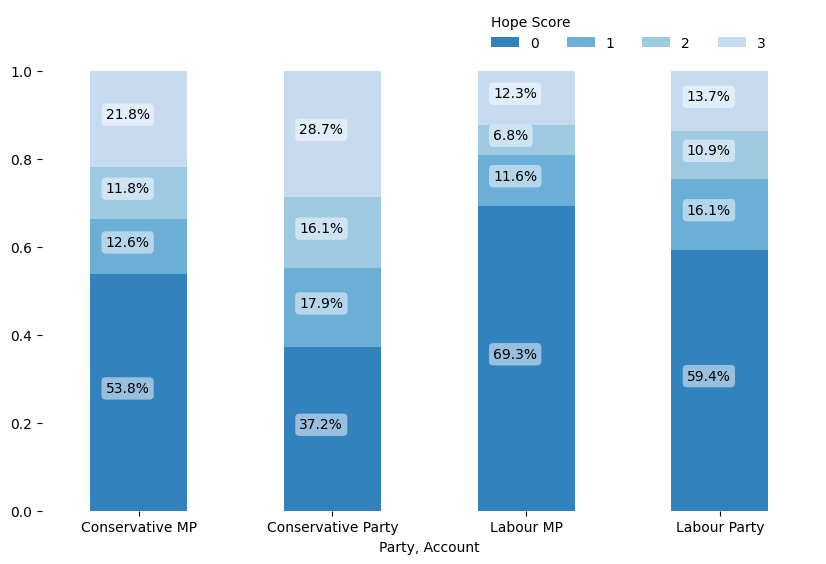

In [30]:
_, _ = chart_crosstab('hope_score', 'Hope Score')

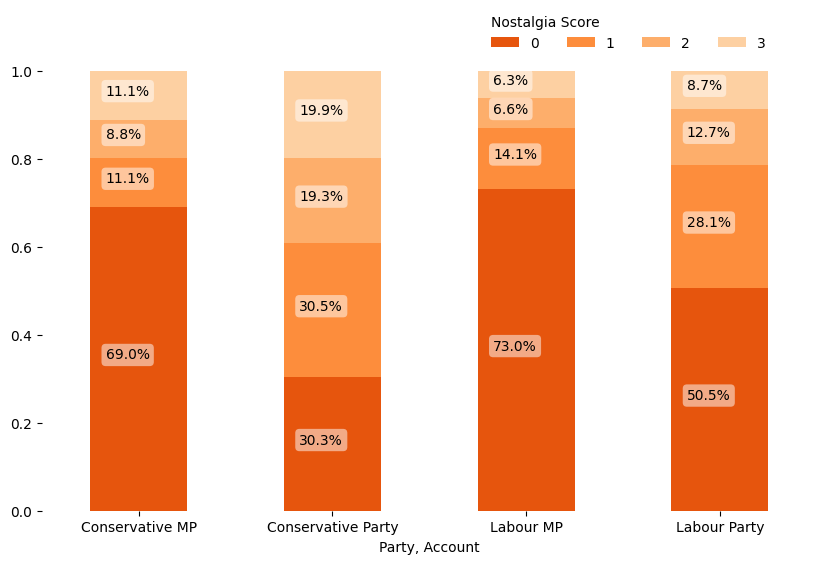

In [31]:
_,_ = chart_crosstab('nostalgia_score', 'Nostalgia Score')

### Statistical Analysis
With only four levels, our indices are less interval than ordinal distributed, so ANOVA or t-tests might not be the best choices. Therefore, I use the Kruskal-Wallis (Kruskal & Wallis, 1952) and Mann-Whitney U-Test (Mann & Whitney, 1947) to compare the groups. As effect size, I will calculate the probability of superiority, i.e., the probability that a random value from group A is larger than a random value from group B (Parker et al., 2020).

In [32]:
def stat_analysis (score):
  print('Difference between Conservatives (Group A) and Labour (Group B) in general')
  labour = transcripts_channels['Party'] == 'Labour'
  conservatives_score = transcripts_channels.loc[~labour, score]
  labour_score = transcripts_channels.loc[labour, score]
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
  u, p = stats.mannwhitneyu(x=conservatives_score,
                            y=labour_score,
                            alternative = 'two-sided')
  n1 = len(conservatives_score)
  n2 = len(labour_score)
  ps = round(u/(n1*n2)*100,2)
  print(f"u: {round(u, 2)}")
  print(f"p: {round(p, 3)}")
  print(f"ps: {ps}")

  print('\nDifferences between the four groups')
  split_groups = []
  gb = transcripts_channels.groupby('Party, Account')  #https://stackoverflow.com/a/23691168/23292830
  split_groups = [gb.get_group(x)[score] for x in gb.groups]
  H, p = stats.kruskal(split_groups[0], #https://www.geeksforgeeks.org/how-to-perform-a-kruskal-wallis-test-in-python/
                        split_groups[1],
                        split_groups[2],
                        split_groups[3])
  H = round(H, 2)
  p = round(p, 3)
  s1 = f"According to the Kruskal-Wallis test, the {score} differs significantly"
  print(s1, f"\n between the groups; H(3, n = 5154) = {H}, p = {p}.")

  print('\nPost-Hoc tests: Whitney U test')
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
  res = []
  for a, b in itertools.combinations(gb.groups, 2): #https://stackoverflow.com/a/16603357
    print(f'\nComparison of {a} with {b}')
    n1 = len(gb.get_group(a))
    n2 = len(gb.get_group(b))
    u, p = stats.mannwhitneyu(x=gb.get_group(a)[score],
                                y=gb.get_group(b)[score],
                                alternative = 'two-sided')
    ps = round(u/(n1*n2)*100,2)
    print(f"u: {round(u, 2)}")
    print(f"p: {round(p, 3)}")
    print(f"ps: {ps}")

    res.append([a, b, u, p, ps])
  return res

In [33]:
res = stat_analysis('hope_score')

Difference between Conservatives (Group A) and Labour (Group B) in general
u: 4123504.0
p: 0.0
ps: 62.1

Differences between the four groups
According to the Kruskal-Wallis test, the hope_score differs significantly 
 between the groups; H(3, n = 5154) = 319.26, p = 0.0.

Post-Hoc tests: Whitney U test

Comparison of Conservative MP with Conservative Party
u: 451625.0
p: 0.0
ps: 41.98

Comparison of Conservative MP with Labour MP
u: 192784.0
p: 0.0
ps: 58.54

Comparison of Conservative MP with Labour Party
u: 572617.0
p: 0.001
ps: 54.33

Comparison of Conservative Party with Labour MP
u: 837581.5
p: 0.0
ps: 66.92

Comparison of Conservative Party with Labour Party
u: 2520521.5
p: 0.0
ps: 62.93

Comparison of Labour MP with Labour Party
u: 555914.0
p: 0.0
ps: 45.33


In [34]:
hope_score_stats = pd.DataFrame(res, columns = ['Group A', 'Group B', 'Whitney U', 'p', 'Probability of Superiority'])
hope_score_stats.to_csv('hope_score_stats.csv')
hope_score_stats.round(3)

,Group A,Group B,Whitney U,p,Probability of Superiority
0,Conservative MP,Conservative Party,451625.0,0.000,41.98
1,Conservative MP,Labour MP,192784.0,0.000,58.54
2,Conservative MP,Labour Party,572617.0,0.001,54.33
3,Conservative Party,Labour MP,837581.5,0.000,66.92
4,Conservative Party,Labour Party,2520521.5,0.000,62.93
5,Labour MP,Labour Party,555914.0,0.000,45.33


In [35]:
res = stat_analysis('nostalgia_score')

Difference between Conservatives (Group A) and Labour (Group B) in general
u: 4042025.5
p: 0.0
ps: 60.87

Differences between the four groups
According to the Kruskal-Wallis test, the nostalgia_score differs significantly 
 between the groups; H(3, n = 5154) = 487.66, p = 0.0.

Post-Hoc tests: Whitney U test

Comparison of Conservative MP with Conservative Party
u: 341268.0
p: 0.0
ps: 31.73

Comparison of Conservative MP with Labour MP
u: 173843.5
p: 0.041
ps: 52.79

Comparison of Conservative MP with Labour Party
u: 450103.5
p: 0.0
ps: 42.71

Comparison of Conservative Party with Labour MP
u: 903465.5
p: 0.0
ps: 72.18

Comparison of Conservative Party with Labour Party
u: 2514613.0
p: 0.0
ps: 62.78

Comparison of Labour MP with Labour Party
u: 480471.0
p: 0.0
ps: 39.18


In [36]:
nostalgia_score_stats = pd.DataFrame(res, columns = ['Group A', 'Group B', 'Whitney U', 'p', 'Probability of Superiority'])
nostalgia_score_stats.to_csv('nostalgia_score_stats.csv')
nostalgia_score_stats.round(3)

,Group A,Group B,Whitney U,p,Probability of Superiority
0,Conservative MP,Conservative Party,341268.0,0.000,31.73
1,Conservative MP,Labour MP,173843.5,0.041,52.79
2,Conservative MP,Labour Party,450103.5,0.000,42.71
3,Conservative Party,Labour MP,903465.5,0.000,72.18
4,Conservative Party,Labour Party,2514613.0,0.000,62.78
5,Labour MP,Labour Party,480471.0,0.000,39.18


# References
- Grant MJ, Button CM, Snook B. An Evaluation of Interrater Reliability Measures on Binary Tasks Using d-Prime. Appl Psychol Meas. 2017 Jun;41(4):264-276. doi: 10.1177/0146621616684584. Epub 2016 Dec 29. PMID: 29881092; PMCID: PMC5978587.
- Kruskal, W. H., & Wallis, W. A. (1952). Use of Ranks in One-Criterion Variance Analysis. Journal of the American Statistical Association, 47(260), 583–621. https://doi.org/10.1080/01621459.1952.10483441
- Mann, H. B., & Whitney, D. R. (1947). On a test of whether one of two random variables is stochastically larger than the other. The Annals of Mathematical Statistics, 18(1), 50–60. https://doi.org/10.1214/aoms/1177730491
- McHugh ML. Interrater reliability: the kappa statistic. Biochem Med (Zagreb). 2012;22(3):276-82. PMID: 23092060; PMCID: PMC3900052.
- Müller, S., & Proksch, S.-O. (2023). Nostalgia in European Party Politics: A Text-Based Measurement Approach. British Journal of Political Science, 1–13. https://doi.org/10.1017/S0007123423000571
- Parker, S., Jernigan, R. W., & Lansky, J. M. (2020). When is the Wilcoxon–Mann–Whitney procedure a test of location? Implications for effect‐size measures. British Journal of Mathematical and Statistical Psychology, 73(1), 170–183. https://doi.org/10.1111/bmsp.12162
